<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 5. Кривые валидации и обучения

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve

Мы уже получили представление о проверке модели, кросс-валидации и регуляризации.
Теперь рассмотрим главный вопрос:

**Если качество модели нас не устраивает, что делать?**

- Сделать модель сложнее или упростить?
- Добавить больше признаков?
- Или нам просто нужно больше данных для обучения?

Ответы на данные вопросы не всегда лежат на поверхности.  В частности, иногда использование более сложной модели приведет к ухудшению показателей. Либо добавление наблюдений не приведет к ощутимым изменениям. Способность принять правильное решение и выбрать правильный способ улучшения модели, собственно говоря, и отличает хорошего специалиста от плохого.

Будем работать со знакомыми данными по оттоку клиентов телеком-оператора. 

In [3]:
data = pd.read_csv('../../data/telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values

**Логистическую регрессию будем обучать стохастическим градиентным спуском. Пока объясним это тем, что так быстрее, но далее в программе у нас отдельная статья про это дело.**

In [4]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), 
                       ('sgd_logit', sgd_logit)])
val_train, val_test = validation_curve(logit_pipe, X, y,
                                       'sgd_logit__alpha', alphas, cv=5,
                                       scoring='roc_auc')

**Построим валидационные кривые, показывающие, как качество (ROC AUC) на обучающей и проверочной выборке меняется с изменением параметра регуляризации.**

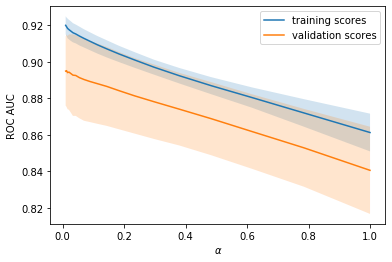

In [5]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend();

Тенденция видна сразу, и она очень часто встречается.

1. Для простых моделей тренировочная и валидационная ошибка находятся где-то рядом, и они велики. Это говорит о том, что модель **недообучилась**: то есть она не имеет достаточное кол-во параметров.

2. Для сильно усложненных моделей тренировочная и валидационная ошибки значительно отличаются. Это можно объяснить **переобучением**: когда параметров слишком много либо не хватает регуляризации, алгоритм может "отвлекаться" на шум в данных и упускать основной тренд.


### Сколько нужно данных?

Известно, что чем больше данных использует модель, тем лучше. Но как нам понять в конкретной ситуации, помогут ли новые данные? Скажем, целесообразно ли нам потратить \$ N на труд асессоров, чтобы увеличить выборку вдвое?

Поскольку новых данных пока может и не быть, разумно поварьировать размер имеющейся обучающей выборки и посмотреть, как качество решения задачи зависит от объема данных, на которм мы обучали модель. Так получаются **кривые обучения** (**learning curves**).

Идея простая: мы отображаем ошибку как функцию от количества примеров, используемых для обучения. При этом параметры модели фиксируются заранее.

In [6]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha))])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()

Давайте посмотрим, что мы получим для линейной модели. Коэффициент регуляризации выставим большим.

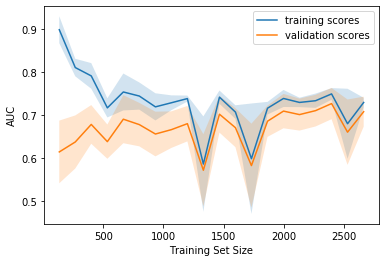

In [7]:
plot_learning_curve(degree=2, alpha=10)

Типичная ситуация: для небольшого объема данных ошибки на обучающей выборке и в процессе кросс-валидации довольно сильно отличаются, что указывает на переобучение.  Для той же модели, но с большим объемом данных ошибки "сходятся", что указывается на недообучение.

Если добавить еще данные, ошибка на обучающей выборке не будет расти, но с другой стороны, ошибка на тестовых данных не будет уменьшаться. 

Получается, ошибки "сошлись", и добавление новых данных не поможет. Собственно, это случай – самый интересный для бизнеса. Возможна ситуация, когда мы увеличиваем выборку в 10 раз. Но если не менять сложность модели, это может и не помочь. То есть стратегия "настроил один раз – дальше использую 10 раз" может и не работать. 

Что будет, если изменить коэффициент регуляризации?
Видим хорошую тенденцию – кривые постепенно сходятся, и если дальше двигаться направо (добавлять в модель данные), можно еще повысить качество на валидации. 

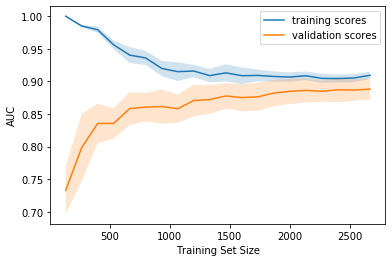

In [8]:
plot_learning_curve(degree=2, alpha=0.05)

А если усложнить ещё больше?

Проявляется переобучение - AUC падает как на обучении, так и на валидации.

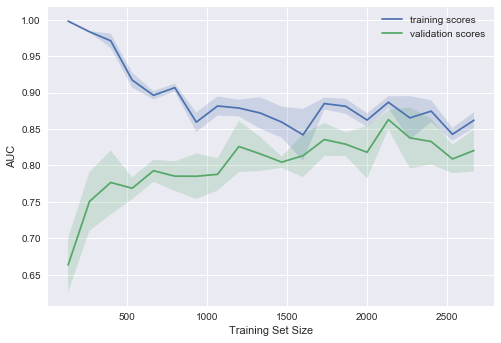

In [16]:
plot_learning_curve(degree=2, alpha=1e-4)

Строя подобные кривые, можно понять, в какую сторону двигаться, и как правильно настроить сложность модели на новых данных.

## Выводы

- Ошибка на обучающей выборке сама по себе ничего не говорит о качестве модели
- Кросс-валидационная ошибка показывает, насколько хорошо модель подстраивается под данные (имеющийся тренд в данных), сохраняя при этом способность обобщения на новые данные
- **Валидационная кривая** представляют собой график, показывающий результат на тренировочной и валидационной выборке в зависимости от **сложности модели**:
  + если две кривые распологаются близко, и обе ошибки велики, -  это признак *недообучения*
  + если две кривые далеко друг от друга, - это показатель *переобучения*
- **Кривая обучения**  - это график, показывающий результаты на валидации и тренировочной подвыборке в зависимости от количества наблюдений. 
  + если кривые сошлись друг к другу, добавление новых данных не поможет – надо менять сложность модели 
  + если кривые еще не сошлись, добавление новых данных может улучшить результат.